<a href="https://colab.research.google.com/github/loiswoo/Time-Series/blob/main/TS_study_w2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Smoothing & Holt Winters Forecast

출처: https://www.kaggle.com/code/prakharprasad/smoothing-holt-winters-forecast

* Hodrick Prescott filter to separate the trend and cyclic components
* Error, Trend and Seasonality Decomposition using Statsmodels Seasonal Decomposition
* Exponential Smoothing using Pandas EWMA and Holt Winters method for Single, Double and Triple Exponential Smoothing
* Forecast into the real future using Holt Winters triple exponential method



In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

## Part 1- Time Series Decomposition

In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from pylab import rcParams
rcParams['figure.figsize'] = (12,5)
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.labelsize'] = 12

## Hodrick Prescott Filter

: trend와 cyclical component를 time series으로부터 분리하기 위해서 사용한다

**Removing the cyclic component essentially, makes the data sensitive to long term fluctuations and not to the short term fluctuations. This is especially important for analyzing the GDP.**


+  Trend vs. Seasonal vs. Cyclical 

Trend(추세): 장기적으로 증가하거나 감소하는 것. 선형적인 필요가 없다


Seasonal(계절성): 주, 월, 분기, 반기 단위 등 특정 시간의 주기로 나타나는 패턴 → 빈도가 일정하다

Cyclical(순환, 주기성): 경기변동과 같이 정치, 경제, 사회적 요인에 의한 변화. 일정 주기(빈도)가 없으며 장기적인 변화 현상

----



ex) 타이레놀의 월별 매출액
* 타이레놀의 월별 매출액에서 '월별'이라는 빈도 존재. 
* 연말에 매출이 높다 → 계절성
* 타이레놀이 코로나로 인하여 매출이 높다 → 순환

In [ ]:
#US Macro economic data
usmacro = pd.read_csv('/content/macrodata.csv',
                      index_col = 0, parse_dates = True) #parse_dates:날짜를 datetime 형태로 변환
                      

In [ ]:
usmacro.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [ ]:
usmacro.dtypes

year          int64
quarter       int64
realgdp     float64
realcons    float64
realinv     float64
realgovt    float64
realdpi     float64
cpi         float64
m1          float64
tbilrate    float64
unemp       float64
pop         float64
infl        float64
realint     float64
dtype: object

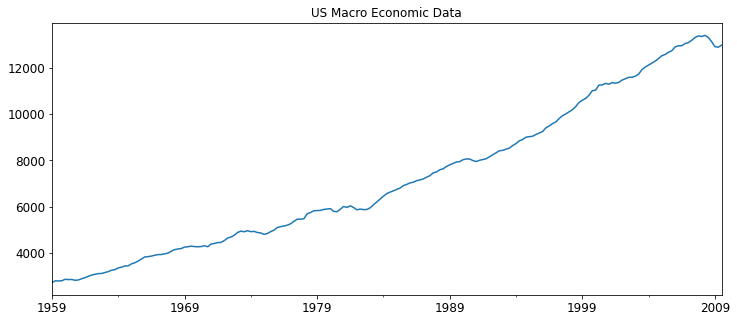

In [ ]:
usmacro['realgdp'].plot(figsize=(12,5), title = 'US Macro Economic Data').autoscale(axis = 'x', tight = True)
#autoscale: axis view를 autoscaling  #tight = True: 데이터의 범위로 그래프 범위 설정

In [ ]:
#tuple unpacking을 통해 trend와 cycles를 분리
cycles, trend = hpfilter(usmacro['realgdp'], lamb = 1600) #hpfilter은 cycle과 trend을 분리 #lamb: smoothing parameter 
                                                                                        # quartely: 1600, yearly: 6.25 , montly: 129,600

In [ ]:
#새로운 열을 추가
usmacro['gdp_trend'] = trend
usmacro['gdp_cycles'] = cycles

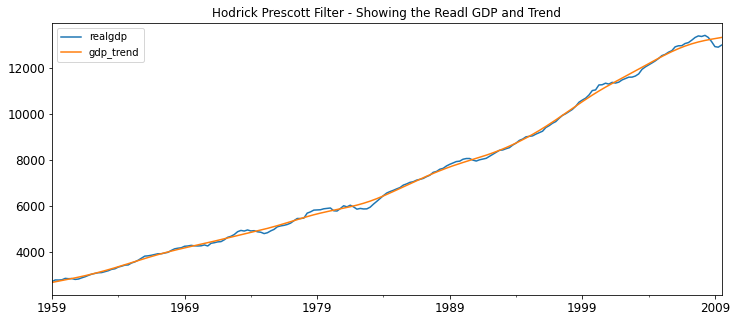

In [ ]:
usmacro[['realgdp', 'gdp_trend']].plot(figsize = (12,5), title = 'Hodrick Prescott Filter - Showing the Readl GDP and Trend').autoscale(axis = 'x', tight = True)

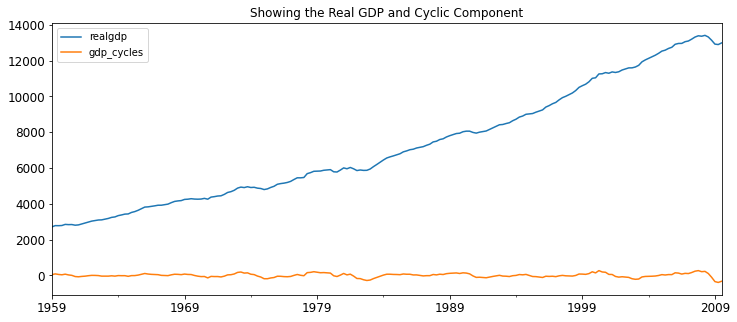

In [ ]:
usmacro[['realgdp', 'gdp_cycles']].plot(figsize = (12, 5), title = 'Showing the Real GDP and Cyclic Component').autoscale(axis = 'x', tight = True)

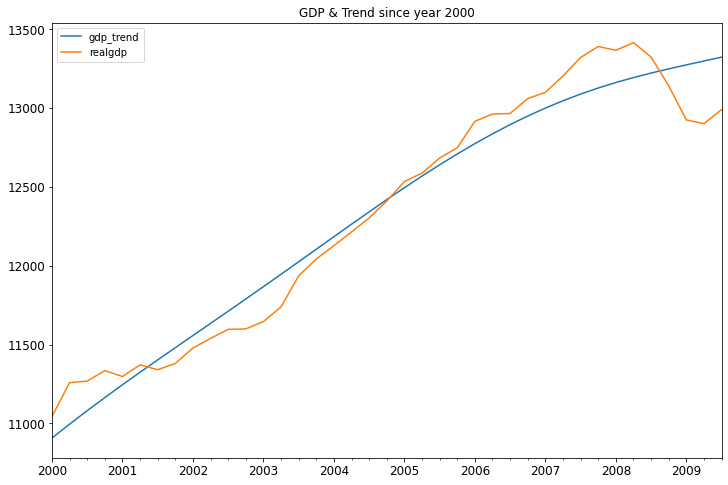

In [ ]:
#2000년대 이후 realgdp와 gdp_trend 확인
usmacro[['gdp_trend', 'realgdp']]['2000-03-31':].plot(figsize = (12,8), title = 'GDP & Trend since year 2000').autoscale(axis = 'x', tight = True)

## ETS - Error, Trend and Seasonality Decomposition

* additive: trend component is constant ex) 20,000 passengers are added every year
* multiplicative: trend increase/decreas at a non linear rate ex) passengers doubled by 20,000 every year

In [ ]:
airline = pd.read_csv('/content/AirPassengers.csv', index_col = 'Month', parse_dates = True)

In [ ]:
airline.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
#Decompose the time series
decompose_result = seasonal_decompose(airline['#Passengers'], model = 'multiplicative')

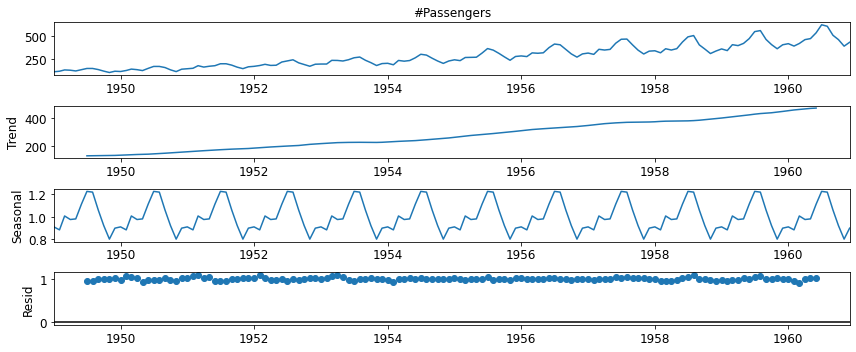

In [ ]:
decompose_result.plot();

## Part 2 - Fit various smoothing models to existing data

## Moving Averages

###SMA - Simple Moving Averages

In [ ]:
airline.dropna(inplace = True)

In [ ]:
airline['6-month-SMA'] = airline['#Passengers'].rolling(window = 6).mean()

In [ ]:
airline['12-month-SMA'] = airline['#Passengers'].rolling(window = 12).mean()

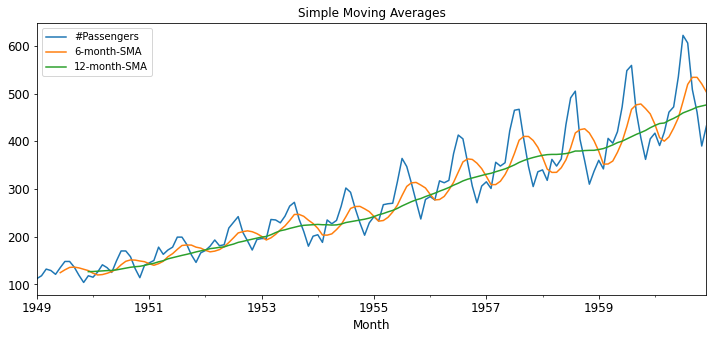

In [ ]:
airline.plot(title = 'Simple Moving Averages');

In [ ]:
airline.head(12)

,#Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,124.500000,NaN
1949-07-01,148,130.500000,NaN
1949-08-01,148,135.500000,NaN
1949-09-01,136,136.166667,NaN


SMA의 단점


*   smaller windows will lead to more noise, rather than signal
*   It will always lag by the size of the window (see the MA starts after a certain lag above in the figure)
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly



### EWMA - Exponentially Weighted Moving Average

최신 값의 가중치를 더 주어서 lag를 줄인다

In [ ]:
airline.head()

,#Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN


In [ ]:
airline['ewma12'] = airline['#Passengers'].ewm(span = 12, adjust = False).mean()

<AxesSubplot:xlabel='Month'>

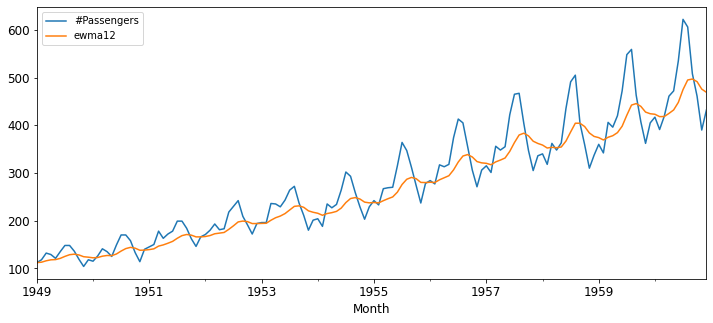

In [ ]:
airline[['#Passengers', 'ewma12']].plot()

### Comparing SMA to EWMA

<AxesSubplot:xlabel='Month'>

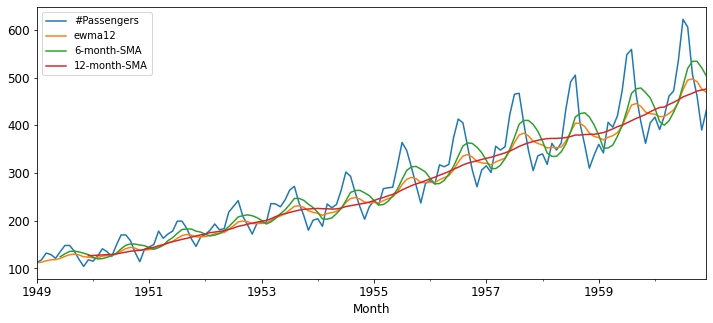

In [ ]:
airline[['#Passengers', 'ewma12', '6-month-SMA', '12-month-SMA']].plot()

## Holt Winters - Simple, Double and Triple Exponential Smoothing

-trend & seasonality series에 적합하다

-Double: smoothing factor for trend
 
-Triple: smoothing factor for seasonality

In [ ]:
#span과 smoothing factor alpha 지정
span = 12
alpha = 2/(span +1)

In [ ]:
airline.columns

Index(['#Passengers', '6-month-SMA', '12-month-SMA', 'ewma12'], dtype='object')

In [ ]:
#Set the frequency of the date time index as Monthly start as indicated by the data
airline.index.freq = 'MS'

In [ ]:
airline.head()

,#Passengers,6-month-SMA,12-month-SMA,ewma12
Month,,,,
1949-01-01,112,NaN,NaN,112.000000
1949-02-01,118,NaN,NaN,112.923077
1949-03-01,132,NaN,NaN,115.857988
1949-04-01,129,NaN,NaN,117.879836
1949-05-01,121,NaN,NaN,118.359861


In [ ]:
airline.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

### Simple Exponential Smoothing - Using Holt Winters

ewm method과 동일

In [ ]:
airline['SES12'] = SimpleExpSmoothing(airline['#Passengers']).fit(smoothing_level = alpha, optimized = False).fittedvalues.shift(-1)

#optimized = False일 때 fit()을 하면 fitted values shifts down one row → shift(-1)을 통해 제자리

In [ ]:
airline.head()

,#Passengers,6-month-SMA,12-month-SMA,ewma12,SES12
Month,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000
1949-02-01,118,NaN,NaN,112.923077,112.923077
1949-03-01,132,NaN,NaN,115.857988,115.857988
1949-04-01,129,NaN,NaN,117.879836,117.879836
1949-05-01,121,NaN,NaN,118.359861,118.359861


<AxesSubplot:title={'center':'Pandas EWMA and Statsmodels Holt Winters Single Exponential Smoothing'}, xlabel='Month'>

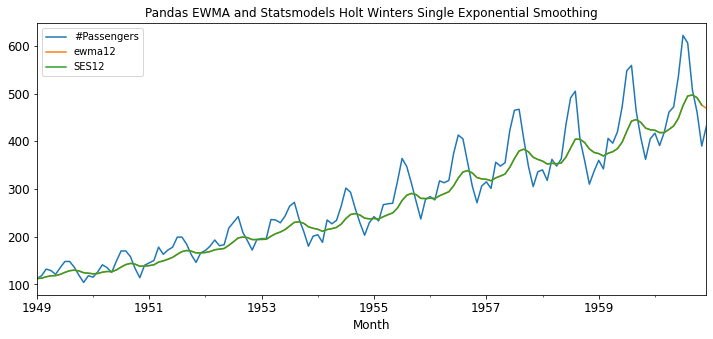

In [ ]:
airline[['#Passengers', 'ewma12', 'SES12']].plot(title = 'Pandas EWMA and Statsmodels Holt Winters Single Exponential Smoothing')


#EWMA 와 Holt Winters Single Exponential Smoothing curve는 동일한 결과 

### Double Exponential Smoothing

In [ ]:
airline['DES12'] = ExponentialSmoothing(airline['#Passengers'], trend = 'add').fit().fittedvalues.shift(-1)

<AxesSubplot:title={'center':'Holt Winters Single & Double Exponential Smoothing'}, xlabel='Month'>

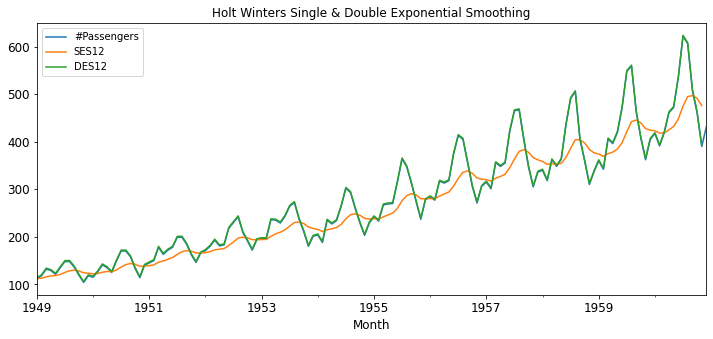

In [ ]:
airline[['#Passengers', 'SES12', 'DES12']].plot(title = 'Holt Winters Single & Double Exponential Smoothing')

#DES와 original data가 완벽하게 일치 

Last 24 months

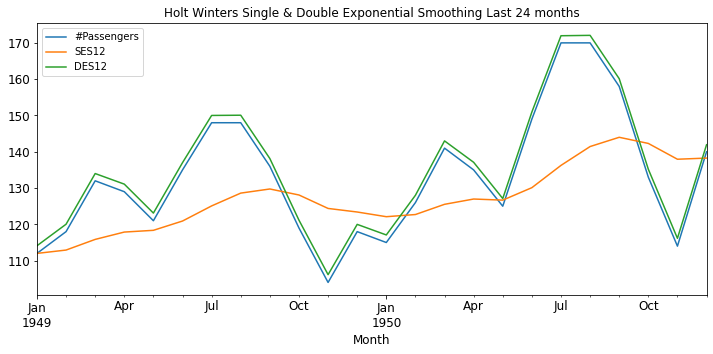

In [ ]:
airline[['#Passengers', 'SES12', 'DES12']].iloc[:24].plot(title = 'Holt Winters Single & Double Exponential Smoothing Last 24 months').autoscale(axis = 'x', tight = True)

Multiplicative Adjustment

In [ ]:
airline['DES12_mul'] = ExponentialSmoothing(airline['#Passengers'], trend = 'mul').fit().fittedvalues.shift(-1)

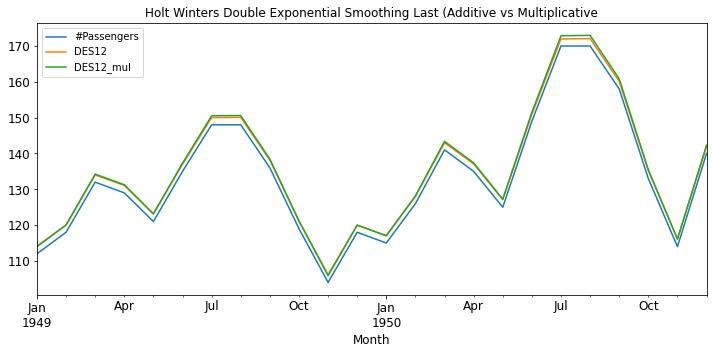

In [ ]:
airline[['#Passengers', 'DES12', 'DES12_mul']].iloc[:24].plot(title = 'Holt Winters Double Exponential Smoothing Last (Additive vs Multiplicative').autoscale(axis = 'x', tight = True)


#흠... 왜 나는 DES_mul 보다 DES가 좋은 결과를 보여주는 거징

## Triple Exponential Smoothing

In [ ]:
airline['TESadd12'] = ExponentialSmoothing(airline['#Passengers'], trend = 'add', seasonal = 'add', seasonal_periods = 12).fit().fittedvalues

In [ ]:
airline.head()

,#Passengers,6-month-SMA,12-month-SMA,ewma12,SES12,DES12,DES12_mul,TESadd12
Month,,,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,114.102394,113.990701,111.959998
1949-02-01,118,NaN,NaN,112.923077,112.923077,120.040657,120.031669,120.193337
1949-03-01,132,NaN,NaN,115.857988,115.857988,134.001539,134.235979,134.676835
1949-04-01,129,NaN,NaN,117.879836,117.879836,131.085845,131.270786,131.407263
1949-05-01,121,NaN,NaN,118.359861,118.359861,123.110263,123.156267,124.643743


In [ ]:
airline['TESmul12'] = ExponentialSmoothing(airline['#Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


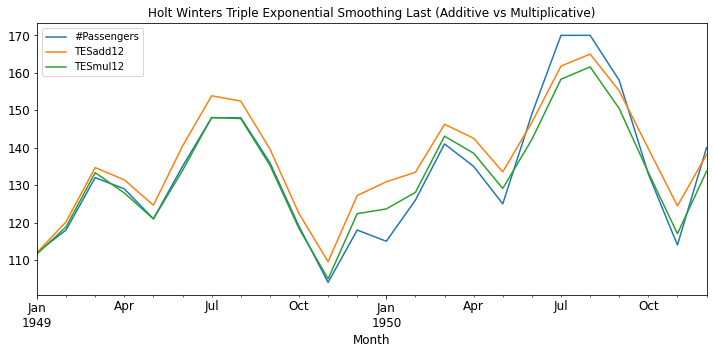

In [ ]:
airline[['#Passengers','TESadd12','TESmul12']].iloc[:24].plot(title='Holt Winters Triple Exponential Smoothing Last (Additive vs Multiplicative)').autoscale(axis='x',tight=True);

#TESadd 보다 TESmul이 좋은 결과

## Part 3 - Forecasting with Holt Winters Method

In [ ]:
airline = pd.read_csv('/content/AirPassengers.csv', index_col = 'Month', parse_dates = True)

In [ ]:
airline.index.freq = 'MS'

In [ ]:
airline.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [ ]:
airline.tail()

,#Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [ ]:
len(airline)

144

### Spliting into Train & Test sets

In [ ]:
train_airline = airline[:108]
test_airline = airline[108:]

In [ ]:
len(test_airline)

36

### Fit the model on the train set

 **We can Assume Seasonality repeated every 12 months**

In [ ]:
fitted_model = ExponentialSmoothing(train_airline['#Passengers'], trend = 'mul', seasonal = 'mul', seasonal_periods = 12).fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [ ]:
test_predictions = fitted_model.forecast(36).rename('HW Test Forecast')

In [ ]:
test_predictions[:10]

1958-01-01    356.968658
1958-02-01    344.588831
1958-03-01    405.718358
1958-04-01    400.610839
1958-05-01    409.001684
1958-06-01    480.694276
1958-07-01    530.470211
1958-08-01    523.288770
1958-09-01    454.210800
1958-10-01    392.518290
Freq: MS, Name: HW Test Forecast, dtype: float64

Text(0.5, 1.0, 'Train and Test Data')

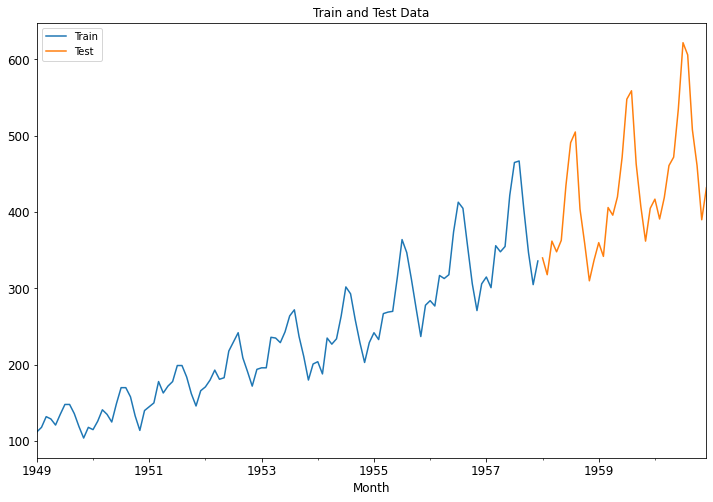

In [ ]:
train_airline['#Passengers'].plot(legend = True, label ='Train')
test_airline['#Passengers'].plot(legend = True, label = 'Test', figsize = (12, 8))
plt.title('Train and Test Data')

Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

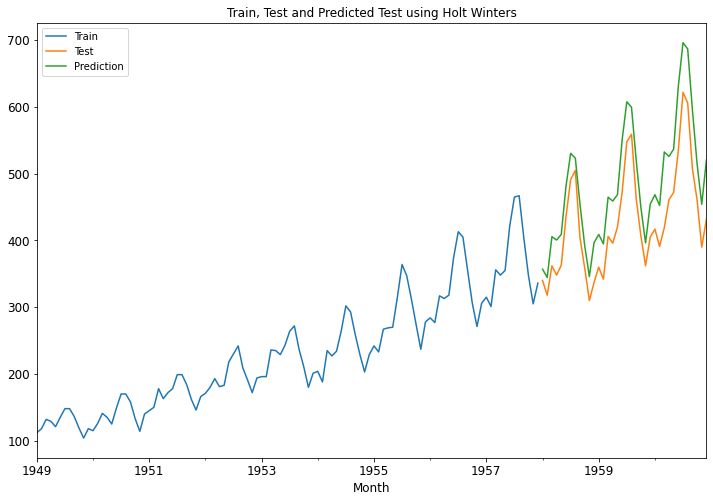

In [ ]:
train_airline['#Passengers'].plot(legend = True, label = 'Train')
test_airline['#Passengers'].plot(legend = True, label = 'Test', figsize = (12, 8))
test_predictions.plot(legend = True, label = 'Prediction')
plt.title('Train, Test and Predicted Test using Holt Winters')

<AxesSubplot:xlabel='Month'>

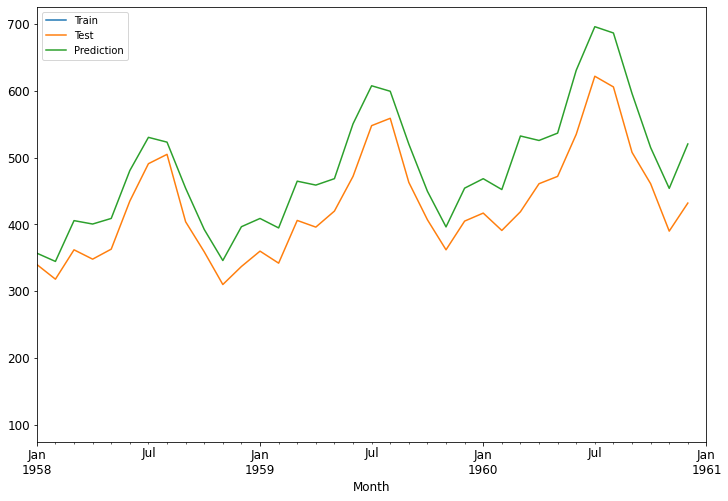

In [ ]:
train_airline['#Passengers'].plot(legend = True, label = 'Train')
test_airline['#Passengers'].plot(legend = True, label = 'Test', figsize = (12,8))
test_predictions.plot(legend = True, label = 'Prediction', xlim = ['1958-01-01', '1961-01-01'])
#오호... xlim을 통해 그래프 범위의 일부분을 보여줄 수 있넴 

### Evaluation metrics

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [ ]:
print(f'Mean Absolute Error = {mean_absolute_error(test_airline, test_predictions)}')

Mean Absolute Error = 55.698326986164496


In [ ]:
print(f'Mean Squared Error = {mean_squared_error(test_airline, test_predictions)}')

Mean Squared Error = 3525.9322806129094


In [ ]:
test_airline.describe()

,#Passengers
count,36.000000
mean,428.500000
std,79.329152
min,310.000000
25%,362.000000
50%,412.000000
75%,472.000000
max,622.000000


### Forecast into the Future

In [ ]:
final_model = ExponentialSmoothing(airline['#Passengers'], trend = 'mul', seasonal= 'mul', seasonal_periods = 12).fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [ ]:
forecast_predictions = final_model.forecast(steps = 36)

Text(0.5, 1.0, 'Airline Passenger Forecast')

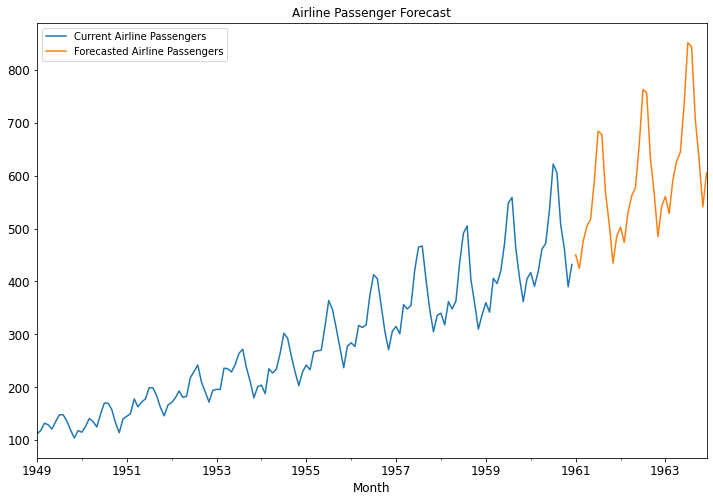

In [ ]:
airline['#Passengers'].plot(figsize = (12, 8), legend = True, label = 'Current Airline Passengers')
forecast_predictions.plot(legend = True, label = 'Forecasted Airline Passengers')
plt.title('Airline Passenger Forecast')